## CNN for Ambient Brightness Recognition

## 0. import packages

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from PIL import Image

In [2]:
print(f"Nvidia GPU: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")

Nvidia GPU: True
Current Device: cuda


## 1. Data Preparation

In [3]:
#load date to train, valid and test
train_path = "./Train"
valid_path = "./Valid"
test_path = "./Test"

In [4]:
def compress_images(path, target_size=(640, 480)):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path)
                    img = img.resize(target_size, Image.ANTIALIAS)
                    img.save(img_path)
                    print(f"Successfully compressed {img_path}")
                except Exception as e:
                    print(f"Error compressing {img_path}: {e}")

compress_images(train_path)
compress_images(valid_path)
compress_images(test_path)

In [5]:
train_data = ImageFolder(train_path, transform=transforms.ToTensor())
print(train_data)
valid_data = ImageFolder(valid_path, transform=transforms.ToTensor())
print(valid_data)
test_data = ImageFolder(test_path, transform=transforms.ToTensor())
print(test_data)

Dataset ImageFolder
    Number of datapoints: 1260
    Root location: ./Train
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 418
    Root location: ./Valid
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 414
    Root location: ./Test
    StandardTransform
Transform: ToTensor()


In [6]:
# Shape of the data

for x, y in train_data:
    print(x.shape)
    print(y)
    break

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

for x, y in train_loader:
    print(x.shape)
    print(y)
    break

print("Num of Img in Training Set:", len(train_data))
print("Num of Img in Test Set:", len(test_data))

torch.Size([3, 480, 640])
0
torch.Size([10, 3, 480, 640])
tensor([3, 0, 0, 0, 3, 1, 3, 3, 3, 2])
Num of Img in Training Set: 1260
Num of Img in Test Set: 414


## 5.CNN Model

In [7]:
class CNN(nn.Module):
    def __init__(self, out_channels) -> None:
        super(CNN, self).__init__()

        # Level 1: (0 + 24) / 2 = 12
        # Level 2: (25 + 49) / 2 = 37
        # Level 3: (50 + 74) / 2 = 62
        # Level 4: (75 + 100) / 2 = 87
        self.brightness_levels = 4
        self.out_channels = out_channels

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.out_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(self.out_channels)

        self.out_channels *= 2

        self.conv2 = nn.Conv2d(in_channels=self.out_channels//2, out_channels=self.out_channels, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(self.out_channels)

        self.out_channels *= 2

        self.conv3 = nn.Conv2d(in_channels=self.out_channels//2, out_channels=self.out_channels, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(self.out_channels)

        # A size of 640x480 picture is reduced by a factor of 2 three times in three pooling layers -> 80x60.
        self.fc = nn.Linear(self.out_channels * 80 * 60, self.brightness_levels)

    def forward(self, x):

        x = self.batch_norm1(self.pool(torch.relu(self.conv1(x))))
        x = self.batch_norm2(self.pool(torch.relu(self.conv2(x))))
        x = self.batch_norm3(self.pool(torch.relu(self.conv3(x))))

        # Resize the input from 4D to 3D wrt to the batch size in order to fit the input size of FC layer
        x = x.view(-1, self.out_channels * 80 * 60)

        return torch.softmax(self.fc(x), dim=1)

## 6. Training

In [8]:
def get_accuracy(model, data, batch_size=32):
    # note: why should we use a larger batch size here?
    loader = DataLoader(data, batch_size=batch_size)

    model.eval() # annotate model for evaluation (why do we need to do this?)

    correct = 0
    total = 0

    # Loader returns images and corresponding labels in a batch
    # imgs = a batch of imgs at current iteration
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        output = model(imgs)

        # output.max(1, keepdim=True) returns the index of highest prob in softmax
        _, pred = output.max(1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct/total

In [9]:
def train(model, train_data, valid_data, batch_size=64, weight_decay=0.0,
          optimizer="sgd", momentum=0.9, learning_rate=0.001, num_epochs=7,
          shuffle_data=True, checkpoint_path=None, print_acc=True):

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_data, drop_last=True)

    criterion = nn.CrossEntropyLoss()

    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)

    iters, losses, train_acc, val_acc, n = [], [], [], [], 0

    print("\n ----- Start Training ----- \n")

    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # Start training mode
            model.train()

            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
            n += 1

        iters.append(n)
        losses.append(float(loss)/batch_size)
        train_acc.append(get_accuracy(model, train_data, batch_size))
        val_acc.append(get_accuracy(model, valid_data, batch_size))

        if checkpoint_path is not None:
            weight_path = checkpoint_path + f'Weight{epoch}.ckpt'
            torch.save(model.state_dict(), weight_path)

        if print_acc:
            print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                    n, val_acc[-1] * 100, train_acc[-1] * 100, losses[-1]))

    # Plot Graph
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


 ----- Start Training ----- 

Iter 19. [Val Acc 21%] [Train Acc 21%, Loss 0.012163]
Iter 38. [Val Acc 76%] [Train Acc 77%, Loss 0.011891]
Iter 57. [Val Acc 80%] [Train Acc 82%, Loss 0.011628]
Iter 76. [Val Acc 99%] [Train Acc 100%, Loss 0.011630]
Iter 95. [Val Acc 100%] [Train Acc 100%, Loss 0.011633]
Iter 114. [Val Acc 100%] [Train Acc 100%, Loss 0.011622]
Iter 133. [Val Acc 100%] [Train Acc 100%, Loss 0.011628]
Iter 152. [Val Acc 100%] [Train Acc 100%, Loss 0.011633]
Iter 171. [Val Acc 99%] [Train Acc 100%, Loss 0.011625]
Iter 190. [Val Acc 100%] [Train Acc 100%, Loss 0.011629]


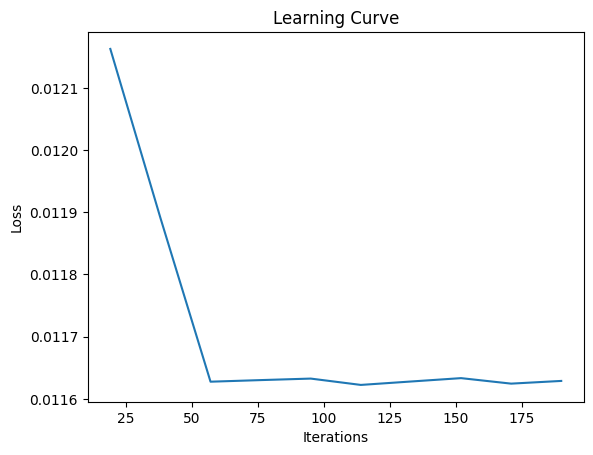

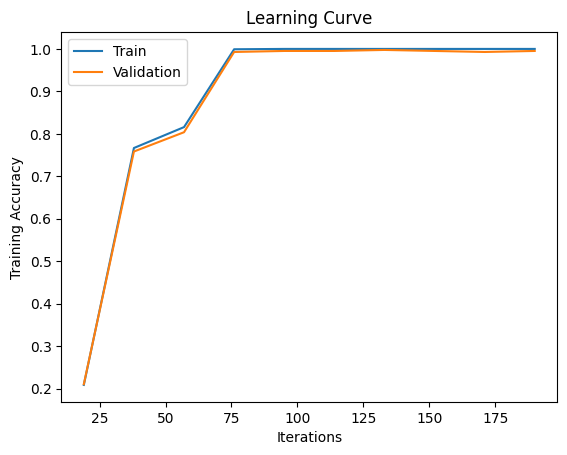

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9952153110047847


In [10]:
# Hyper-parameters
out_channels = 2

model = CNN(out_channels)
model = model.to(device)

checkpoint_path = 'checkpoint/'

train(model, train_data, valid_data, batch_size=64, weight_decay=0.0,
      optimizer="adam", momentum=0.9, learning_rate=0.0001, num_epochs=10,
      shuffle_data=True, checkpoint_path=checkpoint_path)

## 7. Testing

In [20]:
model = CNN(out_channels)
weight_path = checkpoint_path + 'Weight3.ckpt'
model.load_state_dict(torch.load(weight_path))

model = model.to(device)

In [23]:
acc = round(get_accuracy(model, test_data) * 100, 4)
print(f"Test Accuracy: {acc}%")

Test Accuracy: 99.5169%
